<a href="https://colab.research.google.com/github/StefanoBergia/Tesi_Anomaly_Detection/blob/main/UNSUPERVISED_ANOMALY_DETECTION_LSMT_AUTOENCODER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [2]:
!pip install tensorflow-gpu
import tensorflow as tf
from tensorflow import keras

     |████████████████████████████████| 458.3 MB 11 kB/s 


In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from google.colab import drive
from google.colab import widgets
from plotly.subplots import make_subplots
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import DBSCAN
import matplotlib.colors as mcolors
import datetime
import time
import warnings

colors=mcolors.TABLEAU_COLORS
colormap=np.array(list(list(zip(*colors.items()))[1]))
colormap=np.concatenate((colormap, colormap[1:],colormap[1:]), axis=0)

RANDOM_SEED = 161297

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [24]:

#################
min_date='2021-07-21 16:58:36'  ##########attenzione, ci sono tutti i lag
#################

max_date='2021-08-28 00:00:00'

drive.mount('/content/gdrive',force_remount=True)
df_original = pd.read_csv('/content/gdrive/MyDrive/Dati_Tesi/PIVOT_WLS_HVST_1_MONTH.csv', parse_dates=['TS'], index_col='TS')
df_original.index = pd.DatetimeIndex(df_original.index)
df_original=df_original.asfreq(freq='60s',method='ffill')
df=df_original.copy()
df=df.loc[min_date:max_date]

columns=df.columns.drop(['431','907']).drop(['436','480','482','777','781','783','910'])

###########
col='784'
params={
    '272':{'epoch':6,
            'ml':30,
            'ct':0.045,
            'eps':0.0015,
            'rw':0},
    '430':{'epoch':10,
            'ml':15,
            'ct':0.01,
            'eps':0.0015,
            'rw':0},
    '776':{'epoch':5,
            'ml':15,
            'ct':0.01,
            'eps':0.0005,
            'rw':0},
    '780':{'epoch':5,#
            'ml':30,
            'ct':0.01,
            'eps':0.0005,
            'rw':0},
    '782':{'epoch':5,
            'ml':10,
            'ct':0.045,
            'eps':0.005,
            'rw':0},
    '784':{'epoch':3,#controllare
            'ml':30,
            'ct':0.045,
            'eps':0.0015,
            'rw':1},
    '908':{'epoch':6,
            'ml':15,
            'ct':0.05,
            'eps':0.001,
            'rw':0},
    '909':{'epoch':6,#10
            'ml':30,
            'ct':0.05,
            'eps':0.001,
            'rw':1},
}
##########

period_length=1440

print(columns)

Mounted at /content/gdrive
Index(['272', '430', '776', '780', '782', '784', '908', '909'], dtype='object')


In [5]:
first_two_weeks=df.loc['2021-07-24 00:00:00':'2021-08-06 23:59:00']
last_week=df.loc['2021-08-21 00:00:00': '2021-08-28 00:00:00']
strange_week=df.loc['2021-08-14 00:00:00': '2021-08-21 00:00:00']
remove_week=df.loc['2021-08-07 00:00:00':'2021-08-14 00:00:00']

available_lag=df.loc['2021-07-21 16:58:36':'2021-07-24 00:00:00']

strange_week=strange_week*1

last_week.index=strange_week.index
strange_week.index=remove_week.index

df=pd.concat([first_two_weeks, strange_week,last_week])

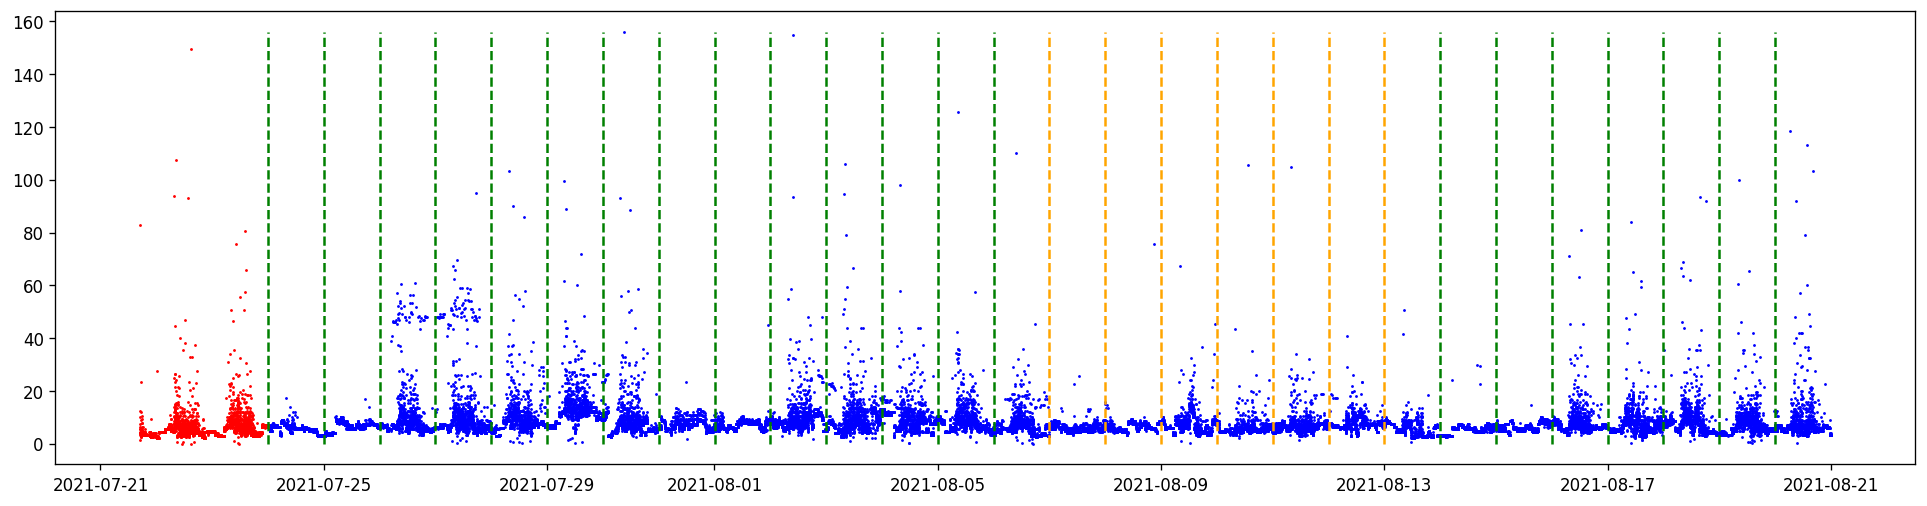

In [6]:
midnights = np.array([])
colors=np.array([])
count=0
for i in range(0,len(df.index),period_length):
  midnights=np.append(midnights,df.index[i])
  if count <14 or count >=28:
    colors=np.append(colors,'green')
  else:
    if count >= 14 and count <21:
      colors=np.append(colors,'orange')
  count=count+1

plt.rcParams.update({'figure.figsize': (25, 10), 'figure.dpi': 120})
fig, ax = plt.subplots(figsize=(20, 5))
ax.scatter(x=df.index, y=df[col], color='blue',s=0.5)
ax.scatter(x=available_lag.index, y=available_lag[col], color='red',s=0.5)
ax.vlines(midnights, df[col].min(), df[col].max(), linestyles='dashed', colors=colors)
fig.show();

In [7]:
TIME_STEPS = 60

lag=available_lag[-TIME_STEPS:]
df_lagged=pd.concat([lag,df])

train=df_lagged.loc[df_lagged.index[0]:'2021-08-21 00:00:00']

print("dataset")
print(df.shape)
print(df.index[0],df.index[-1])
print ("lag")
print(lag.shape)
print(lag.index[0],lag.index[-1])
print("dataset lagged")
print(df_lagged.shape)
print(df_lagged.index[0],df_lagged.index[-1])
print("train")
print(train.shape)
print(train.index[0],train.index[-1])
print("test")

dataset
(40319, 17)
2021-07-24 00:00:36 2021-08-20 23:59:36
lag
(60, 17)
2021-07-23 23:00:36 2021-07-23 23:59:36
dataset lagged
(40379, 17)
2021-07-23 23:00:36 2021-08-20 23:59:36
train
(40379, 17)
2021-07-23 23:00:36 2021-08-20 23:59:36
test


In [8]:
scaler = MinMaxScaler()

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    scaler = scaler.fit(train[[col]])
    train[col] = scaler.transform(train[[col]])


In [9]:
training_sets=np.array([
                        train.loc[df_lagged.index[1]:'2021-07-31 00:00:00'],
                        train.loc[datetime.datetime(2021, 7, 31, 0, 0, 0)-datetime.timedelta(minutes=TIME_STEPS):'2021-08-07 00:00:00'],
                        train.loc[datetime.datetime(2021, 8, 7 , 0, 0, 0)-datetime.timedelta(minutes=TIME_STEPS):'2021-08-14 00:00:00'],
                        train.loc[datetime.datetime(2021, 8, 14, 0, 0, 0)-datetime.timedelta(minutes=TIME_STEPS):'2021-08-21 00:00:00']])

print(training_sets.shape)

(4,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



In [10]:
def create_lagged_dataset(dataset, steps):
    X_lagged= []
    index_lagged=[]
    Y_lagged= []
    for i in range(len(dataset.index) - steps):

        lag = dataset.iloc[i :(i + steps)].values
        X_lagged.append(lag)

        index_lag=dataset.index[i :(i + steps)]
        index_lagged.append(index_lag)

        Y_lagged.append(dataset.iloc[i+steps])
    X_lagged= np.array(X_lagged)
    X_lagged= X_lagged.reshape(X_lagged.shape[0],X_lagged.shape[1],1)
    index_lagged= np.array(index_lagged)
    index_lagged=index_lagged.reshape(index_lagged.shape[0],index_lagged.shape[1],1)
    Y_lagged= np.array(Y_lagged)
    Y_lagged=Y_lagged.reshape(Y_lagged.shape[0],1)
    return  X_lagged,index_lagged, Y_lagged

In [11]:
models=[{},{},{},{}]
i=0;
for t_set in training_sets:
  X_train,index_train, Y_train,= create_lagged_dataset(t_set[col], TIME_STEPS)
  model = keras.Sequential()
  model.add(keras.layers.LSTM(
      units=64, 
      input_shape=(X_train.shape[1], X_train.shape[2])
  ))
  model.add(keras.layers.Dropout(rate=0.2))
  model.add(keras.layers.RepeatVector(n=X_train.shape[1]))
  model.add(keras.layers.LSTM(units=64, return_sequences=True))
  model.add(keras.layers.Dropout(rate=0.2))
  model.add(keras.layers.TimeDistributed(keras.layers.Dense(units=X_train.shape[2])))
  model.compile(loss='mae', optimizer='adam')
  
  print("week "+str(i))
  fitted_model = model.fit(
      X_train, Y_train,
      epochs=params[col]['epoch'],
      batch_size=64,#32
      validation_split=0.1,
      shuffle=False
  )
  
  models[i]={'model':model,'fitted_model':fitted_model, 'data':X_train}
  i=i+1




week 0
Epoch 1/15
142/142 [==============================] - 17s 100ms/step - loss: 0.0198 - val_loss: 0.0272
Epoch 2/15
142/142 [==============================] - 13s 94ms/step - loss: 0.0189 - val_loss: 0.0201
Epoch 3/15
142/142 [==============================] - 13s 94ms/step - loss: 0.0184 - val_loss: 0.0196
Epoch 4/15
142/142 [==============================] - 13s 94ms/step - loss: 0.0180 - val_loss: 0.0203
Epoch 5/15
142/142 [==============================] - 13s 94ms/step - loss: 0.0181 - val_loss: 0.0212
Epoch 6/15
142/142 [==============================] - 13s 93ms/step - loss: 0.0178 - val_loss: 0.0213
Epoch 7/15
142/142 [==============================] - 13s 94ms/step - loss: 0.0179 - val_loss: 0.0219
Epoch 8/15
142/142 [==============================] - 13s 95ms/step - loss: 0.0183 - val_loss: 0.0221
Epoch 9/15
142/142 [==============================] - 14s 95ms/step - loss: 0.0178 - val_loss: 0.0211
Epoch 10/15
142/142 [==============================] - 14s 96ms/step - los

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

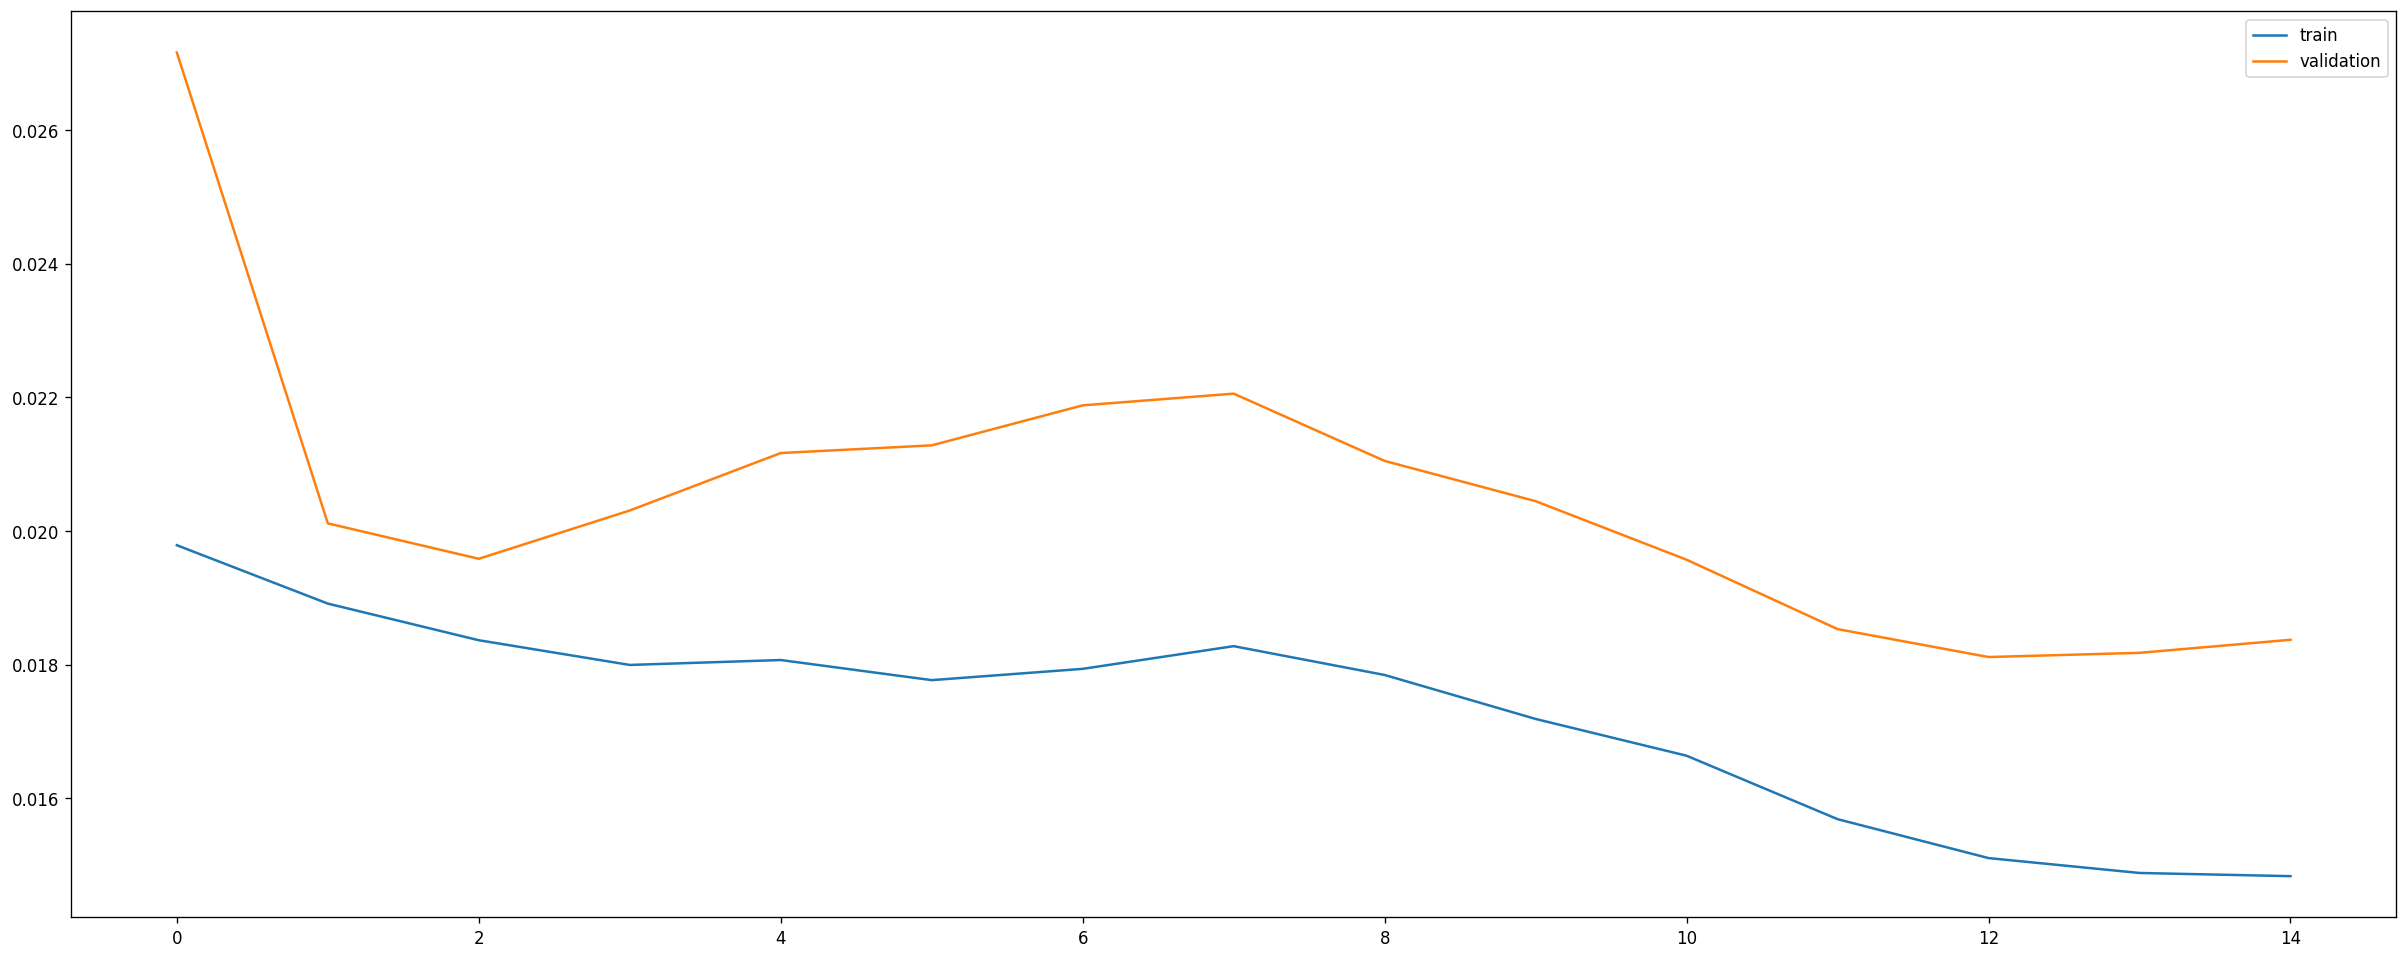

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

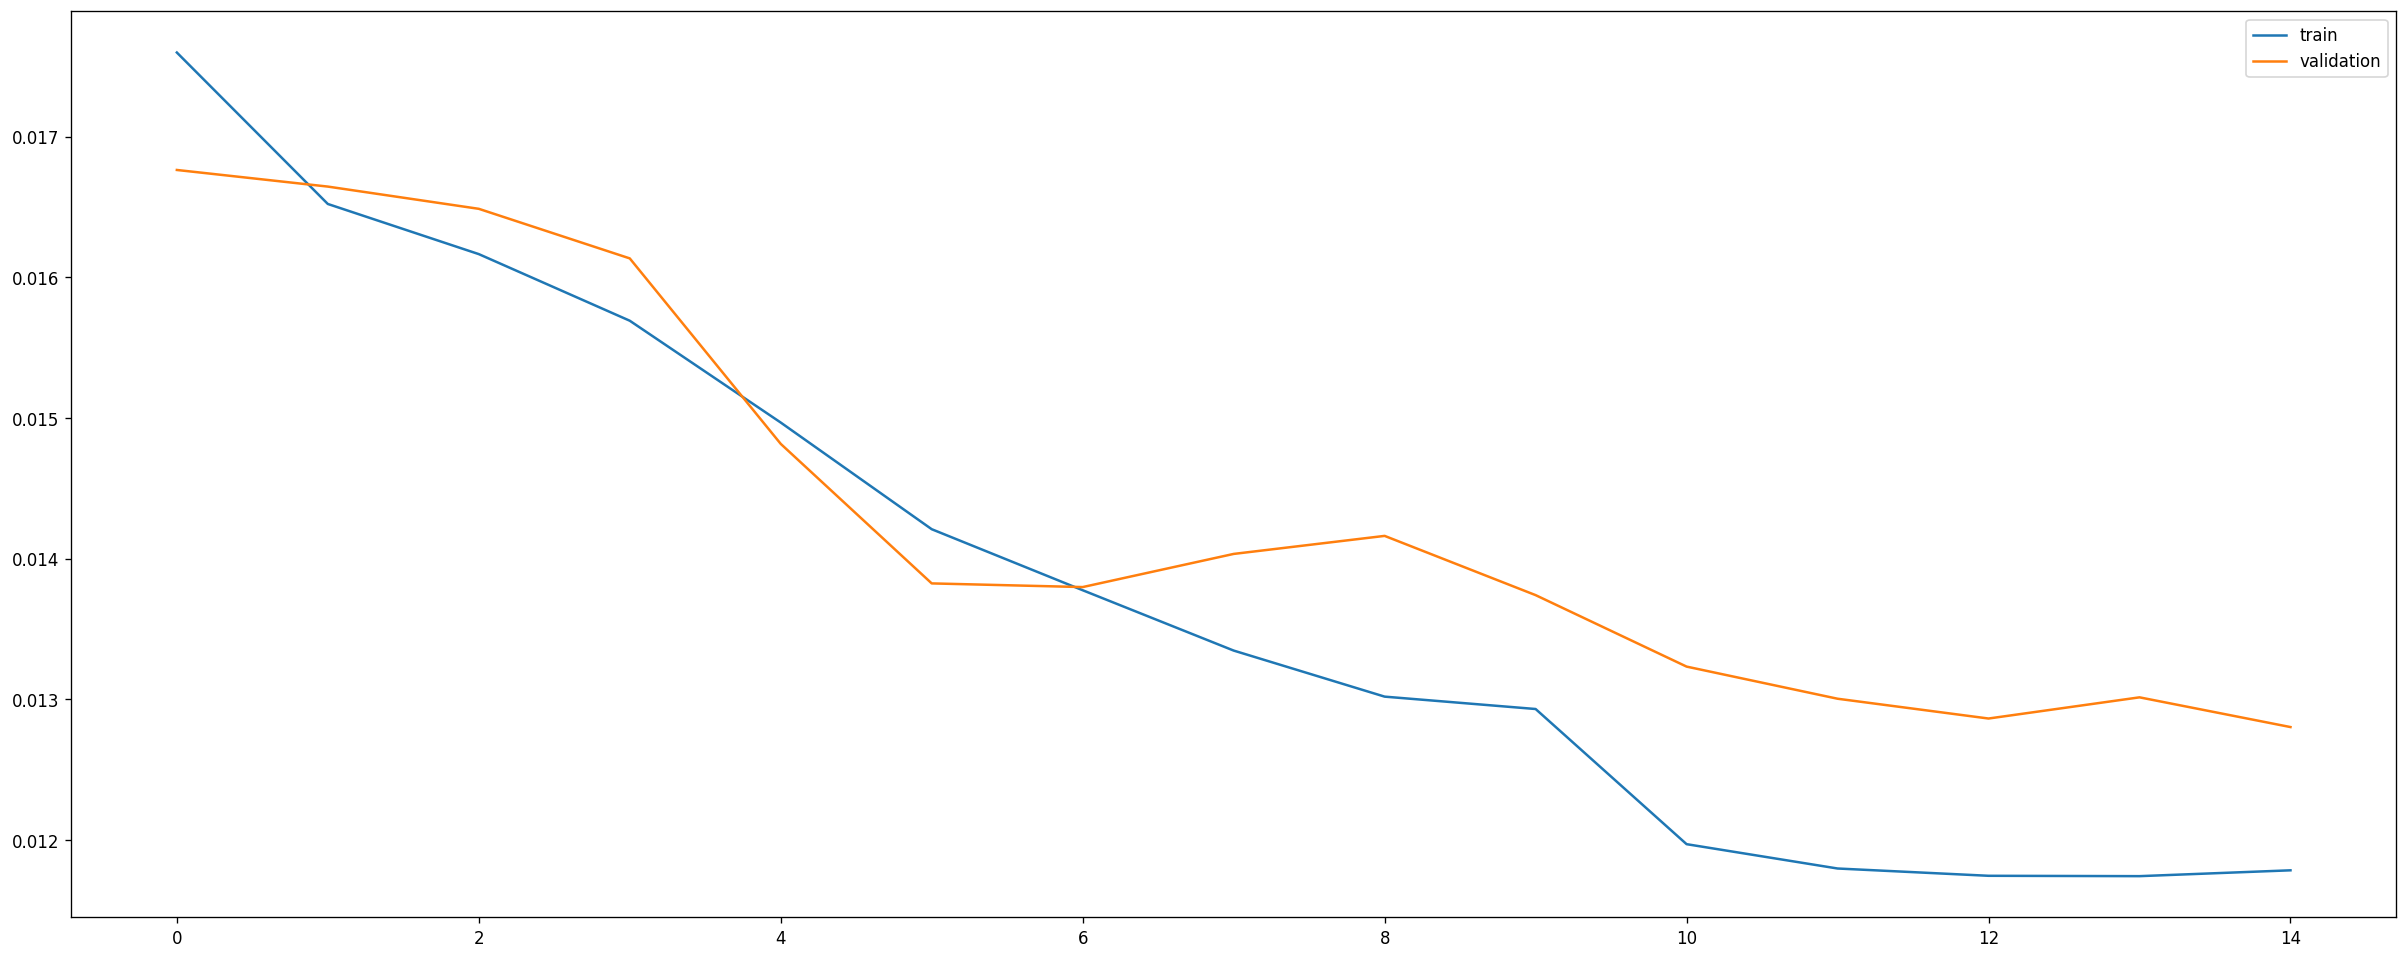

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

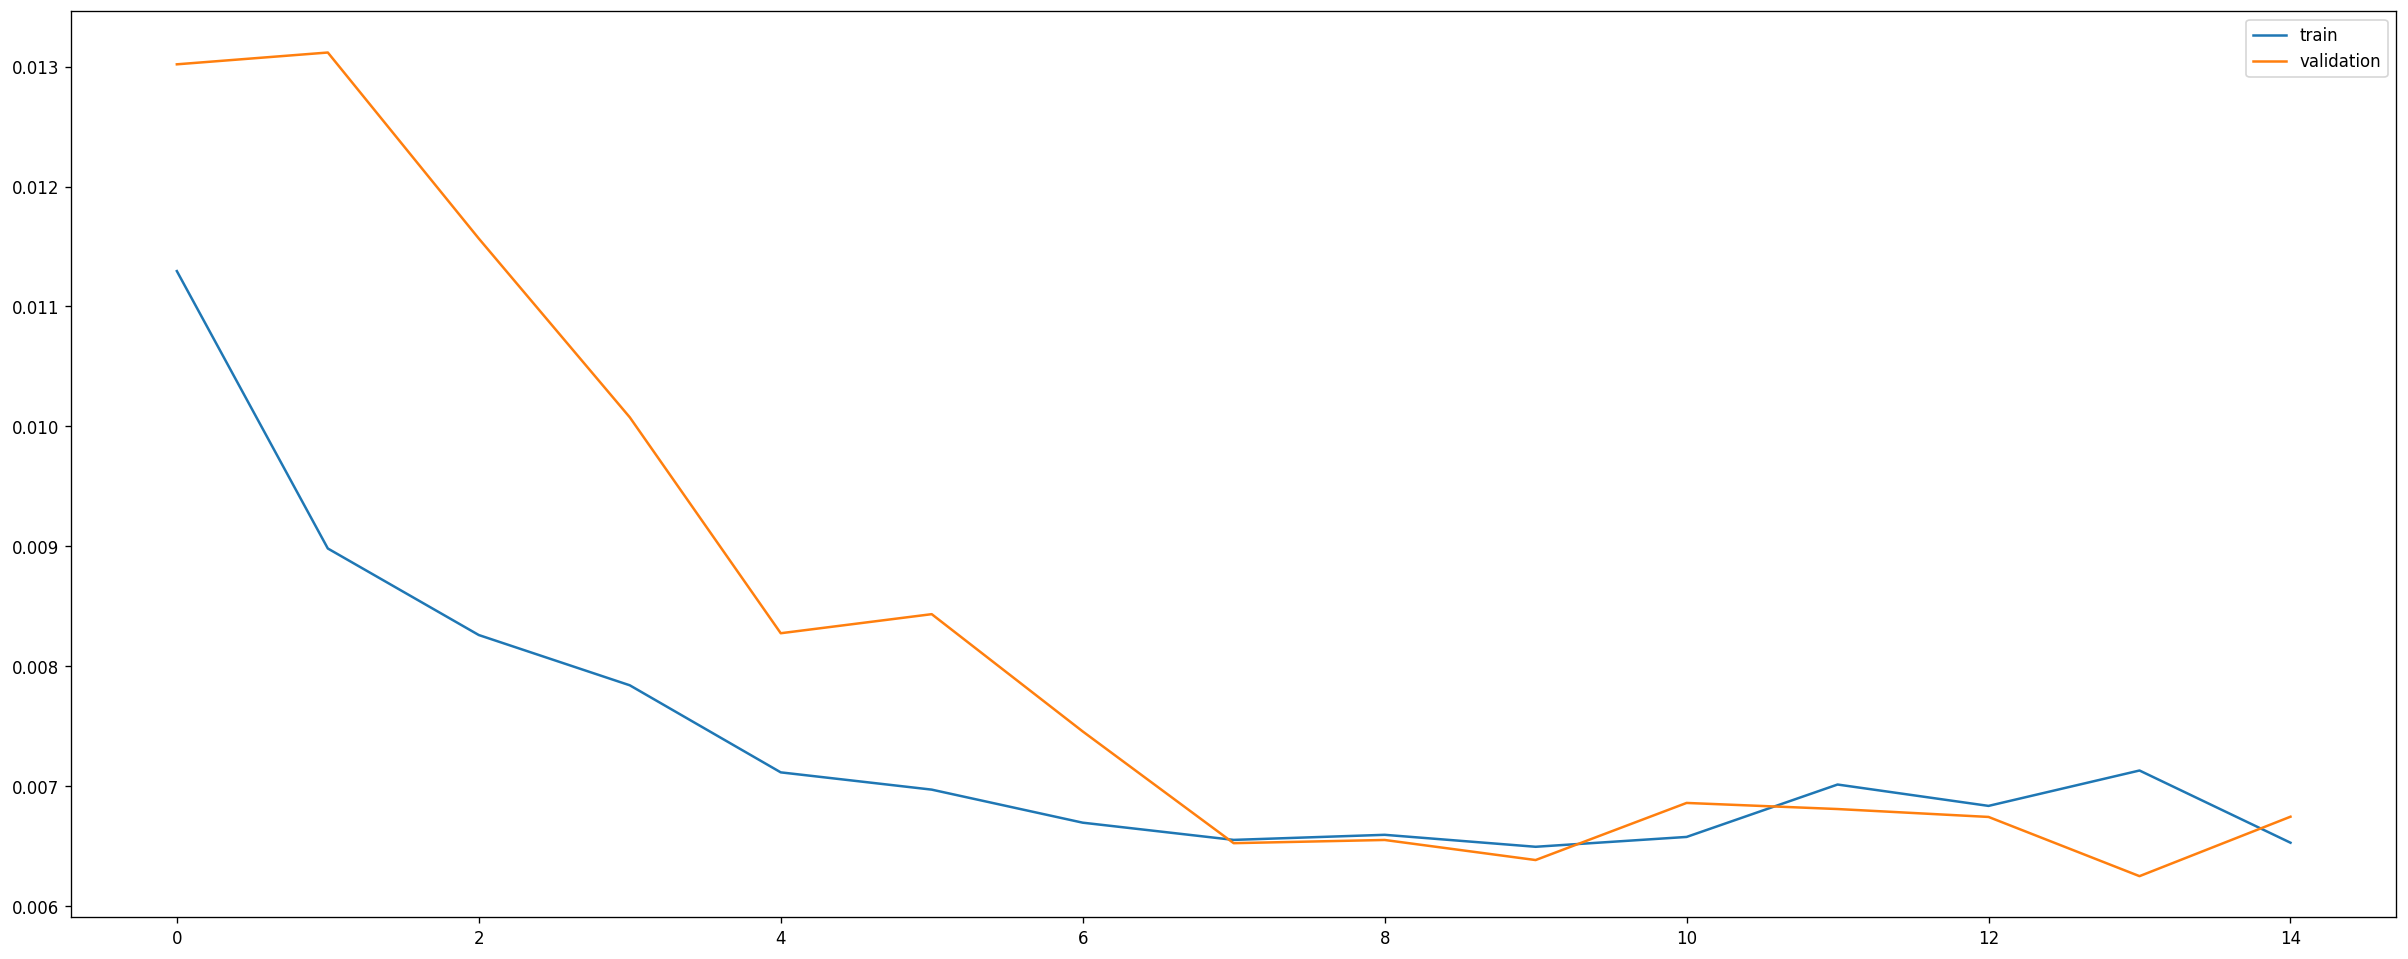

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

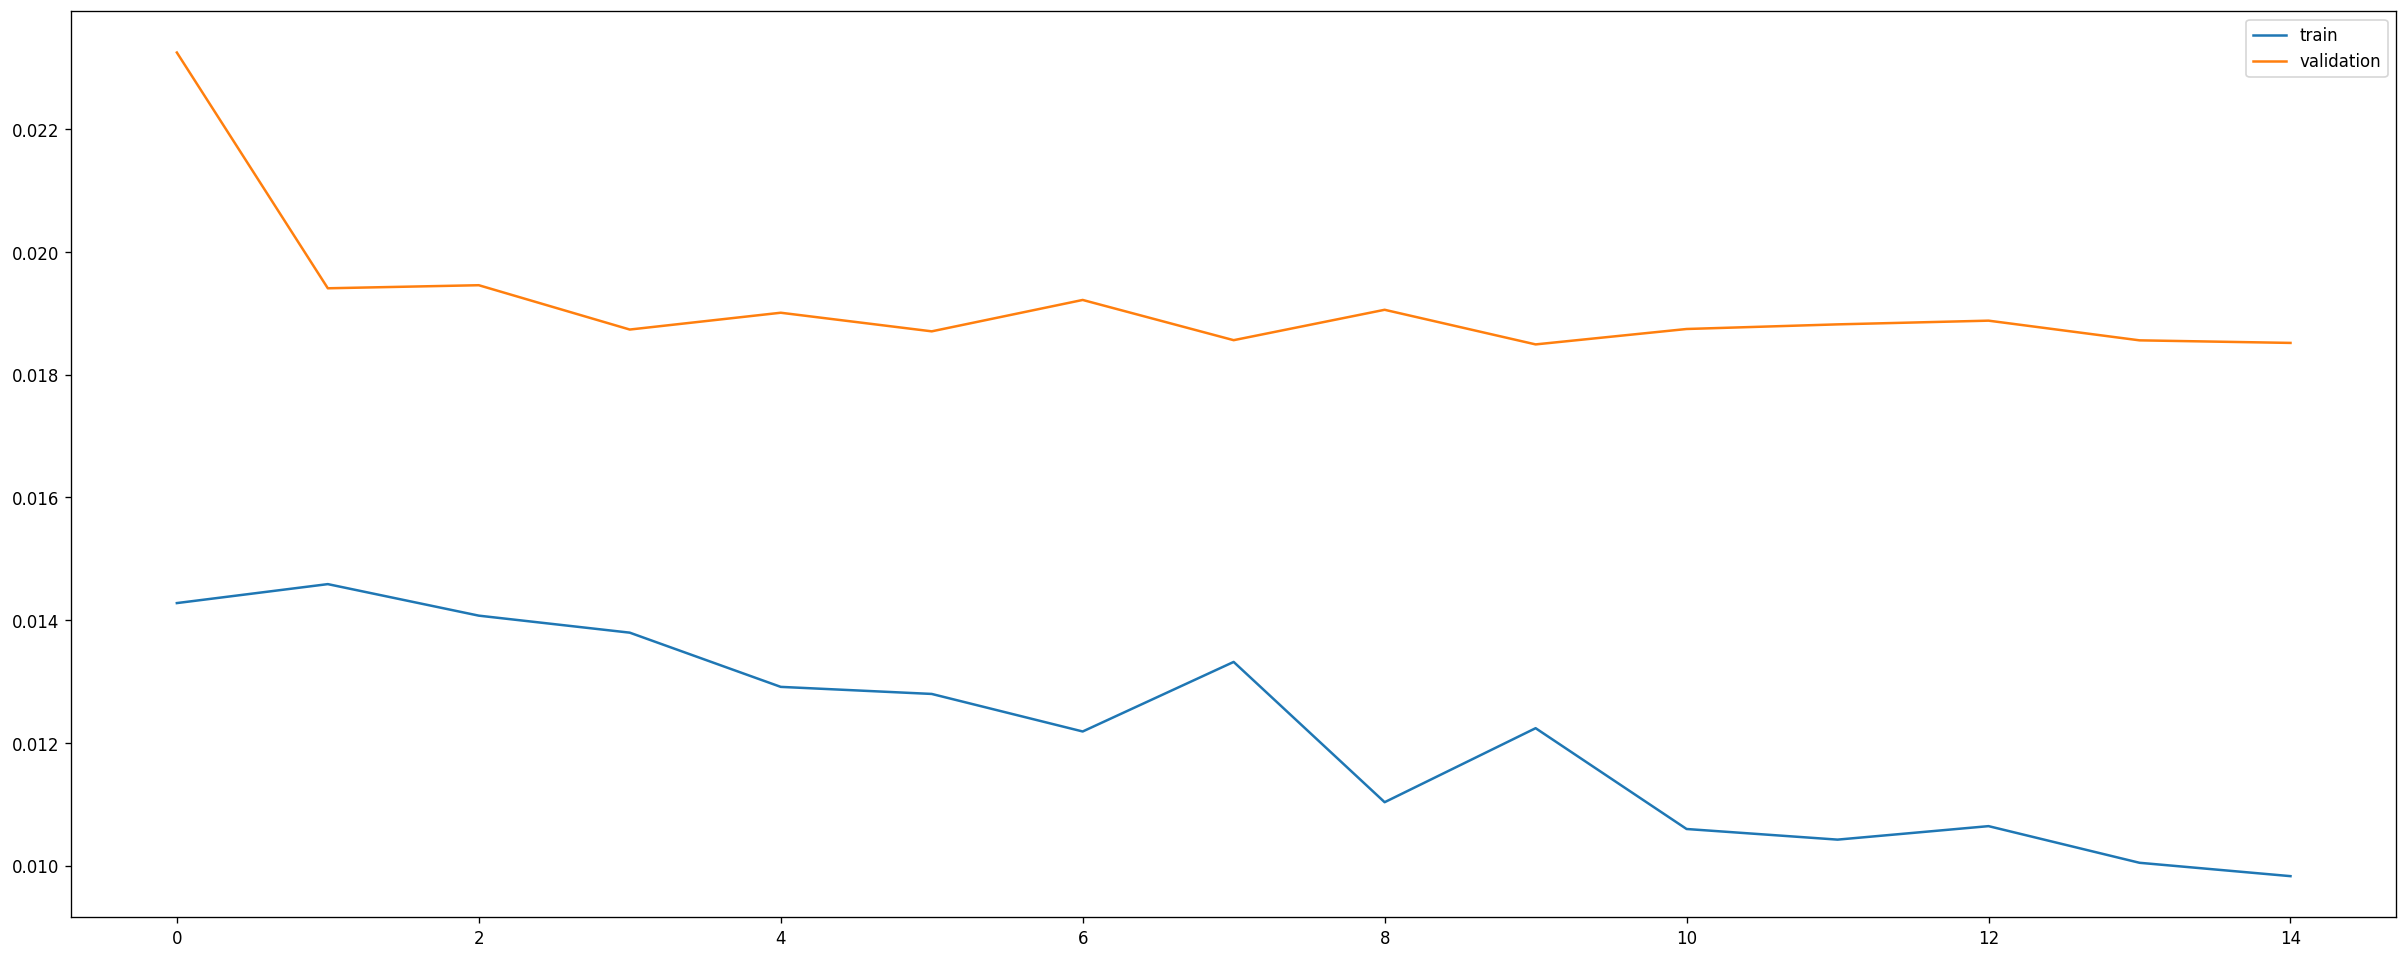

<IPython.core.display.Javascript object>

In [12]:
tb = widgets.TabBar(['week 0','week 1','week 2','week 3'])
i=0
for model in models:
  with tb.output_to('week '+str(i)):
    plt.plot(model['fitted_model'].history['loss'], label='train')
    plt.plot(model['fitted_model'].history['val_loss'], label='validation')
    plt.legend();
  i=i+1

In [13]:
i=0
mae_loss=np.zeros((4*(period_length*7-1),1))
for pred in models:
  avg_mae_loss=np.zeros(((period_length*7-1),1))
  for model in models:
    if not pred == model:
      X_train_pred = model['model'].predict(pred['data'])[0:(period_length*7-1)]
      train_mae_loss = np.mean(np.abs(X_train_pred - pred['data'][0:(period_length*7-1)]), axis=1)
      avg_mae_loss=avg_mae_loss+train_mae_loss
  avg_mae_loss=avg_mae_loss/4
  mae_loss[i*(period_length*7-1):(i+1)*(period_length*7-1)]=avg_mae_loss
  i=i+1

train_score_df = pd.DataFrame(index=train.index[TIME_STEPS+3:])
train_score_df['loss'] = mae_loss


ISOLATION FOREST

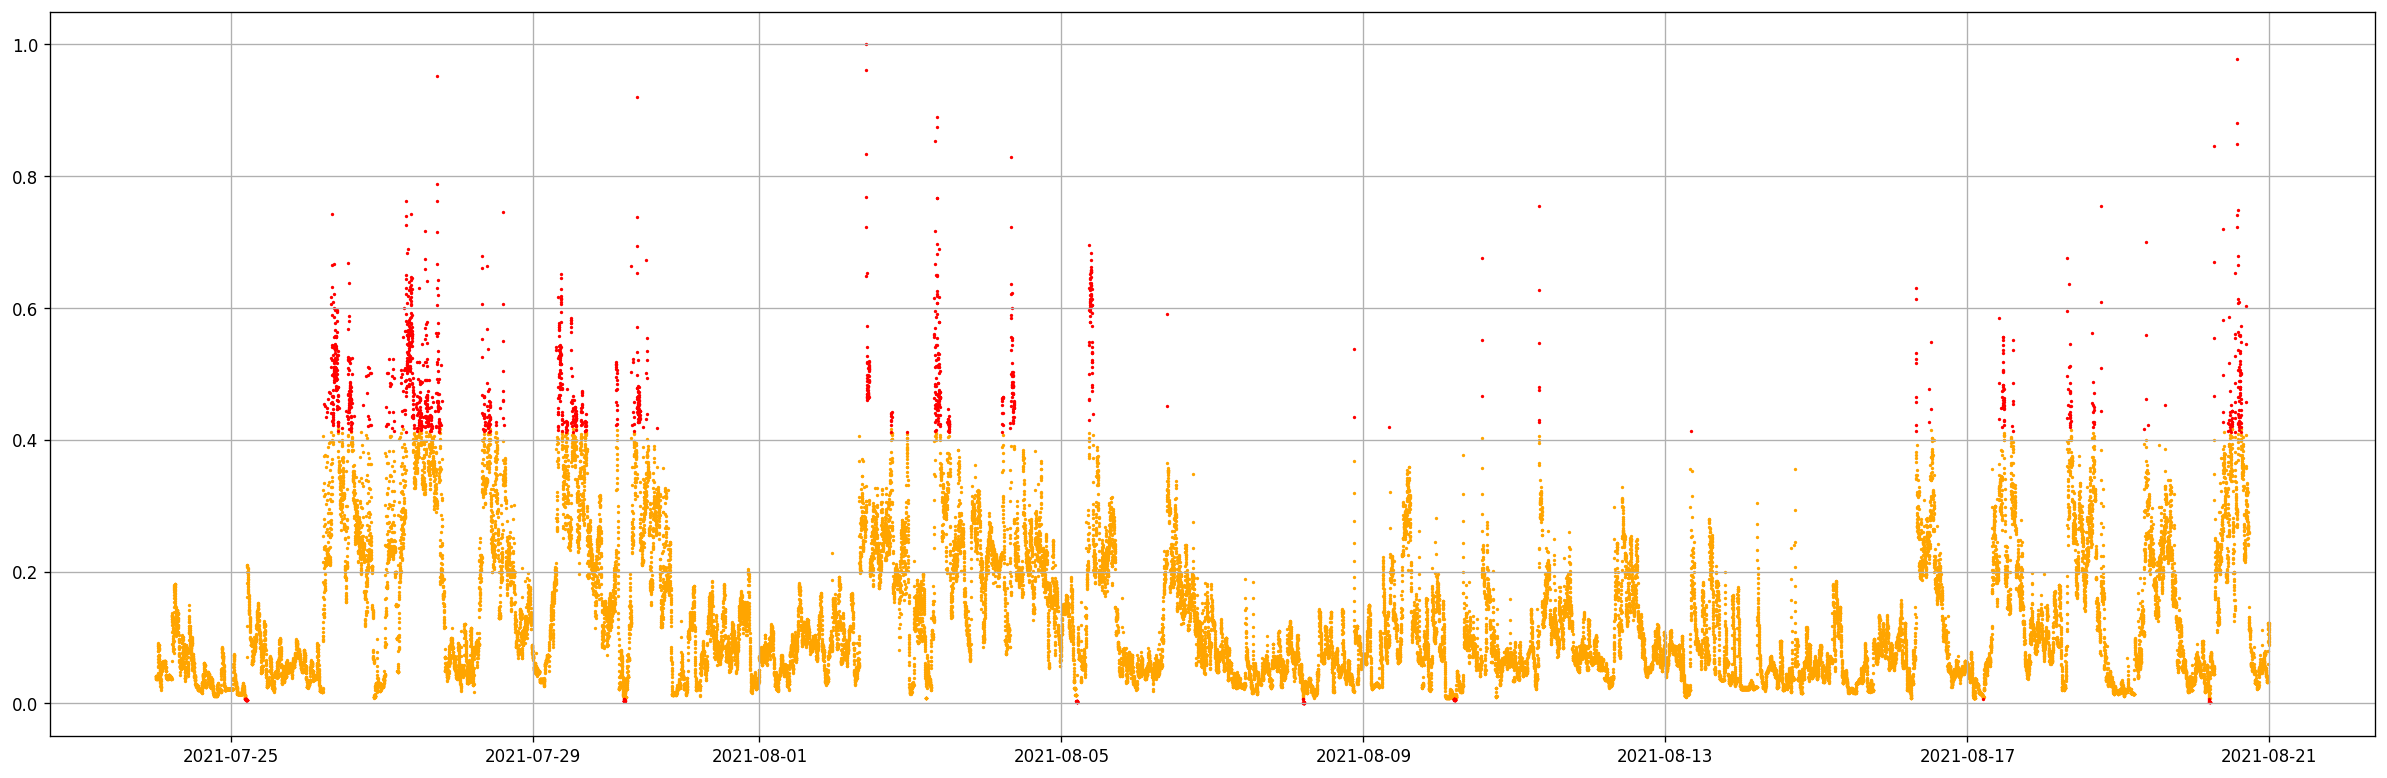

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



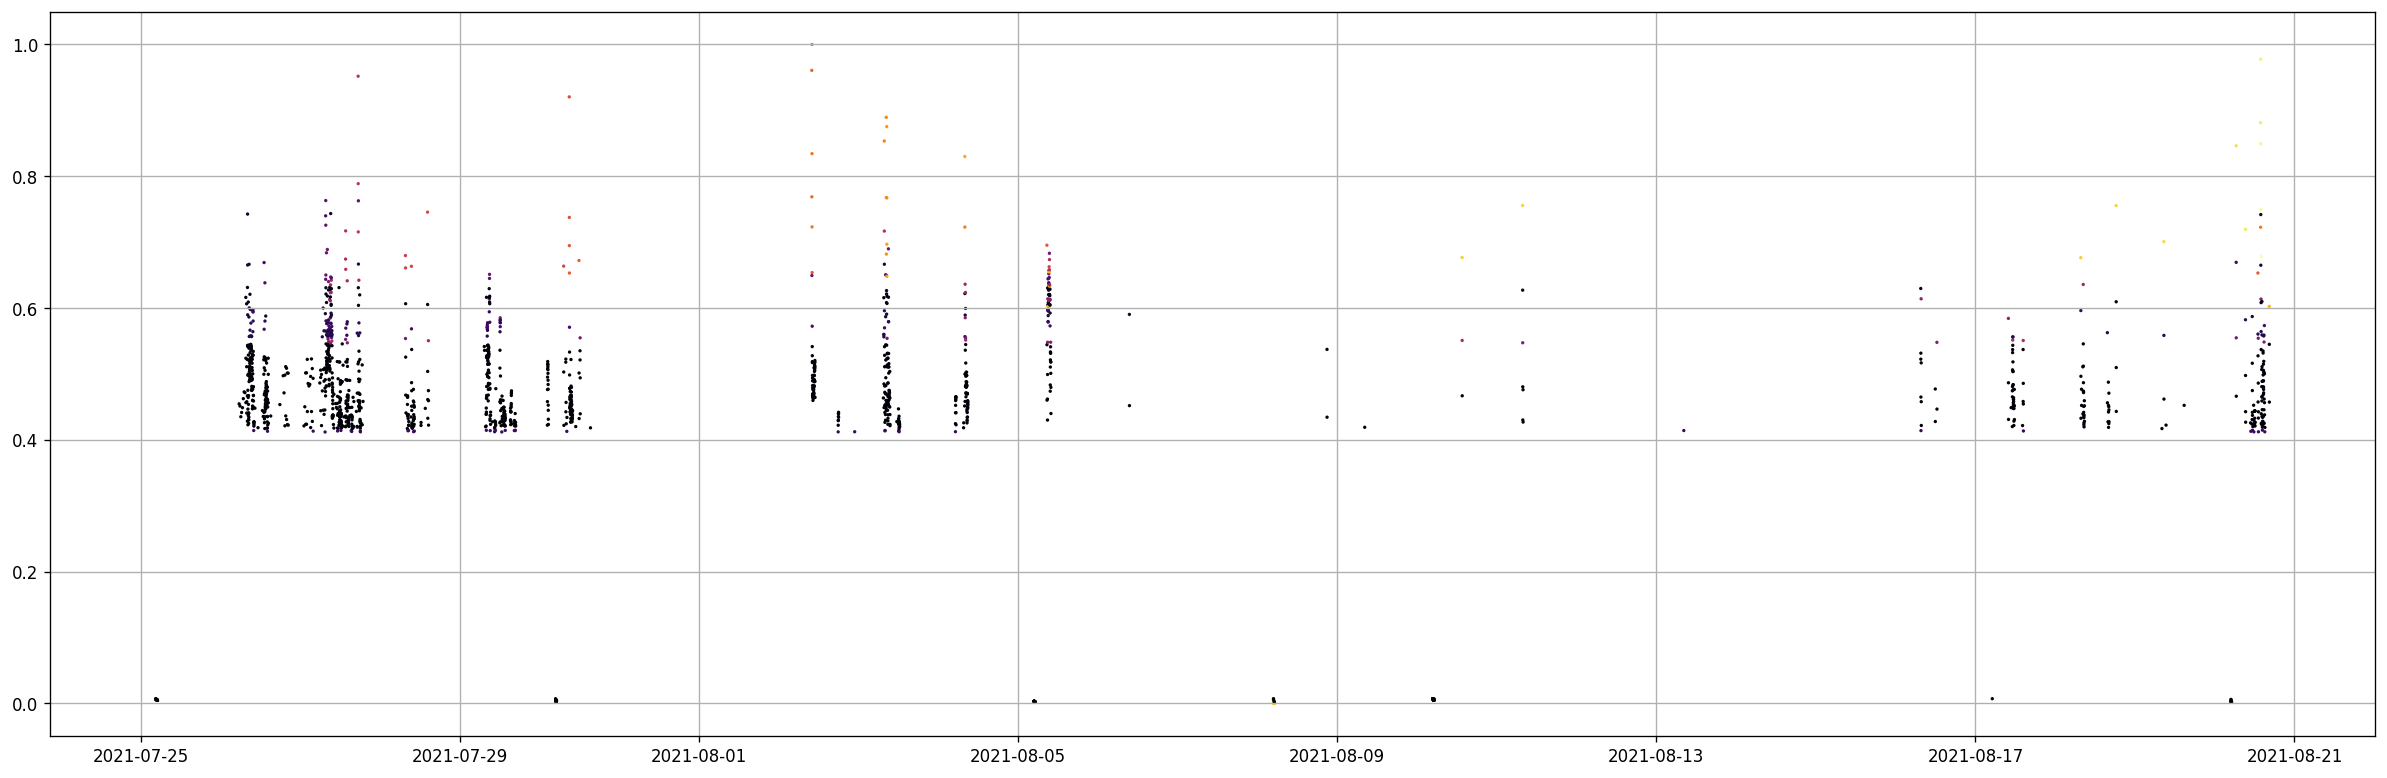

2021-07-26T08:21:36.000000000 2021-07-26T09:58:36.000000000
2021-07-27T07:33:36.000000000 2021-07-27T09:53:36.000000000
2021-07-29T07:56:36.000000000 2021-07-29T09:08:36.000000000
2021-08-03T08:02:36.000000000 2021-08-03T09:18:36.000000000
2021-08-05T08:49:36.000000000 2021-08-05T09:52:36.000000000


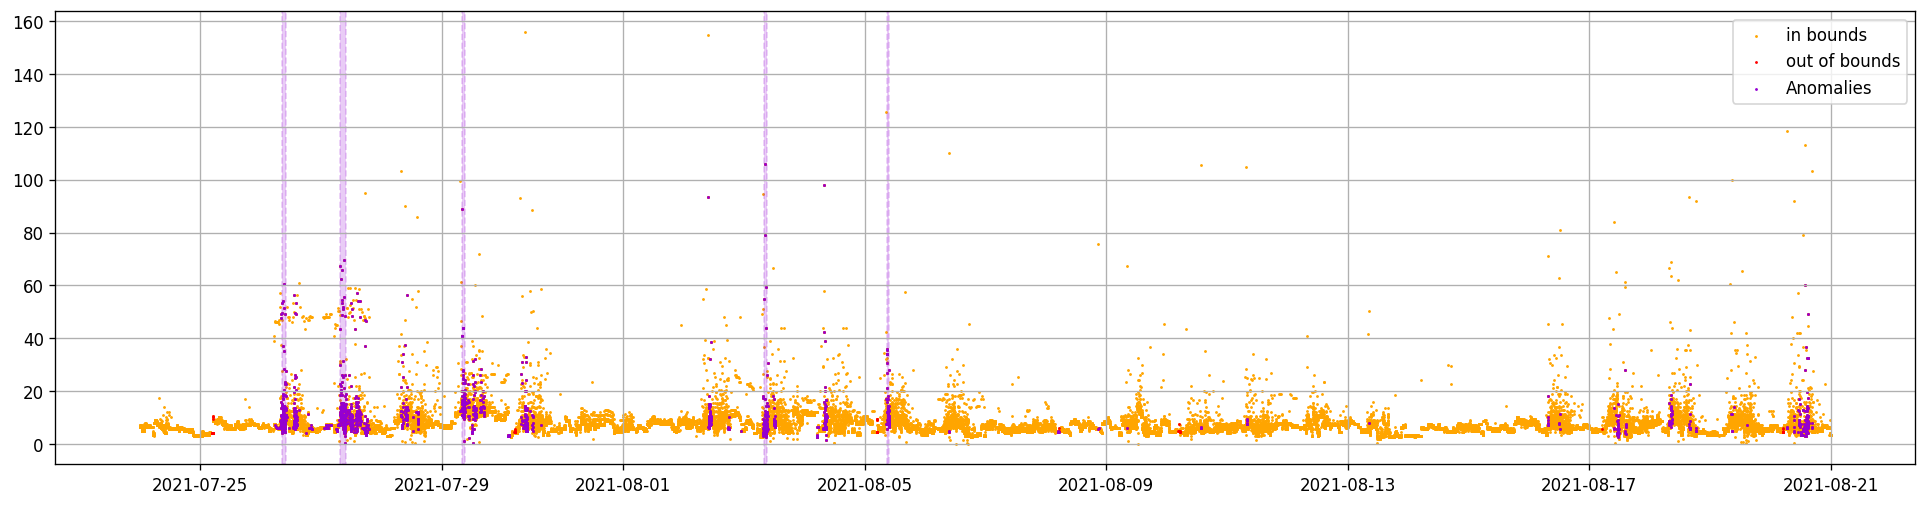

In [23]:
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN
import datetime


scaler = MinMaxScaler()
ts=pd.DataFrame(scaler.fit_transform(train_score_df['loss'].values.reshape(-1,1)))
ts.index = pd.DatetimeIndex(train_score_df.index)
ts=ts.asfreq(freq='60s',method='ffill')
ts=ts.rename(columns={0: "loss"})

model =  IsolationForest(contamination=0.04)                                                         #ISOLATION FOREST
model.fit(ts) 
forecast=model.predict(ts)
ts['anomaly_score']=forecast
out_of_bounds=ts[ts['anomaly_score']==-1]
in_bounds=ts[ts['anomaly_score']==1]


plt.scatter(x=in_bounds.index ,y=ts['loss'].loc[in_bounds.index], color='orange', label='In bounds',s=1)
plt.scatter(x=out_of_bounds.index , y=ts['loss'].loc[out_of_bounds.index], color='red', label='Out of bounds',s=1)
plt.grid()
plt.show()

clustering = DBSCAN(eps=0.001, min_samples=1).fit(out_of_bounds['loss'].to_numpy().reshape(-1, 1))    #DBSCAN
out_of_bounds['label']=clustering.labels_
plt.scatter(x=out_of_bounds.index,
           y=out_of_bounds['loss'],
           c = out_of_bounds['label'],
           cmap = 'inferno',
            s=1)
plt.grid()
plt.show()
anomalies=out_of_bounds[out_of_bounds['label']>0]


fig, ax = plt.subplots(figsize=(20, 5))
plt.rcParams.update({'figure.figsize': (25, 8), 'figure.dpi': 120})
ax.scatter(x=df.index, y=df[col], color='orange',label='in bounds',s=0.5)#
ax.scatter(x=out_of_bounds.index, y=df[col].loc[out_of_bounds.index], label='out of bounds',color='red',s=0.5)#
plt.scatter(x=anomalies.index , y=df[col].loc[anomalies.index],color='darkviolet', label='Anomalies',s=0.5)#

min_lenght=60################

flag=1
if(len(anomalies.index)>0):
  date_low=anomalies.index.values[0]

  for date in anomalies.index.values[1:]:
    if flag==1:
      date_high=date
      flag=0
      if (pd.Timedelta((date_high-date_low)).total_seconds()>60):
        date_low=date_high
        flag=1
      
    else:
      if  pd.Timedelta((date-date_high)).total_seconds()<=60:
        date_high=date
        write_last=1
      else:
        if pd.Timedelta((date_high-date_low)).total_seconds()>=60*min_lenght:
          dl=pd.to_datetime(date_low)
          dh= pd.to_datetime(date_low)
          if  params[col]['rw']==0 or dl.isoweekday()<6  :#
            plt.axvspan(date_low, date_high, alpha=0.2, color='darkviolet',linewidth=1,linestyle='dashed')
            print(date_low, date_high)
        date_low=date
        flag=1
  if  write_last==1 and pd.Timedelta((date_high-date_low)).total_seconds()>=60*min_lenght:
      dl=pd.to_datetime(date_low)
      dh= pd.to_datetime(date_low)
      if  params[col]['rw']==0 or dl.isoweekday()<6  :#
        plt.axvspan(date_low, date_high, alpha=0.2, color='darkviolet',linewidth=1,linestyle='dashed')
        print(date_low, date_high)



plt.grid()
plt.legend()
plt.show()